In [1]:
from pathlib import Path

from rljax.algorithm import DQN
from rljax.trainer import Trainer
import numpy as np
import pandas as pd

from classes import Env, Preprocess

PATH = Path().cwd()

In [2]:
raw = Preprocess(PATH.joinpath('asset_data', 'TBT_TBF_data.csv'), residual_num=7)
data = raw.process()

In [3]:
def return_rewards(current, last, action, p, c):
    return sum(current) - sum(last)

In [4]:
# 23,400 seconds between 9:30am and 4pm broken in 10 second increments

NUM_AGENT_STEPS = 150_000
SEED = 0
DAYS = 1
DAY = 2340//2

env = Env(data, no_trade_period=5, fixed_buy_cost=0.0015, fixed_sell_cost=0.0015, steps=DAY*DAYS, reward_func=return_rewards)
env_test = env.copy_env()

algo = DQN(
    num_agent_steps=NUM_AGENT_STEPS,
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=SEED,
    batch_size=256,
    start_steps=1000,
    update_interval=1,
    update_interval_target=400,
    eps_decay_steps=0,
    loss_type="l2",
    lr=5e-5,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    log_dir="",
    num_agent_steps=NUM_AGENT_STEPS,
    eval_interval=25_000,
    seed=SEED,
)
trainer.train()

Num steps: 25000    Return: 19.9    Time: 0:02:20
Num steps: 50000    Return: 21.5    Time: 0:04:53
Num steps: 75000    Return: 17.6    Time: 0:07:20
Num steps: 100000   Return: 18.3    Time: 0:09:49
Num steps: 125000   Return: 16.7    Time: 0:12:25
Num steps: 150000   Return: 17.2    Time: 0:14:57


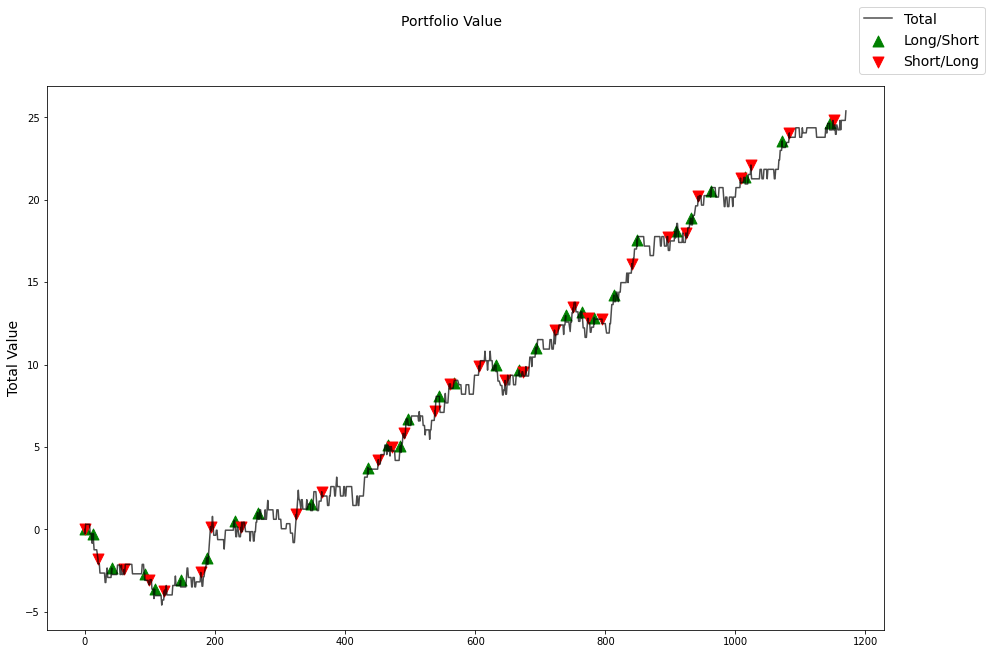

In [5]:
env.plot(fig_name='train_env_pnl_medium_cost_dqn_9_242728')

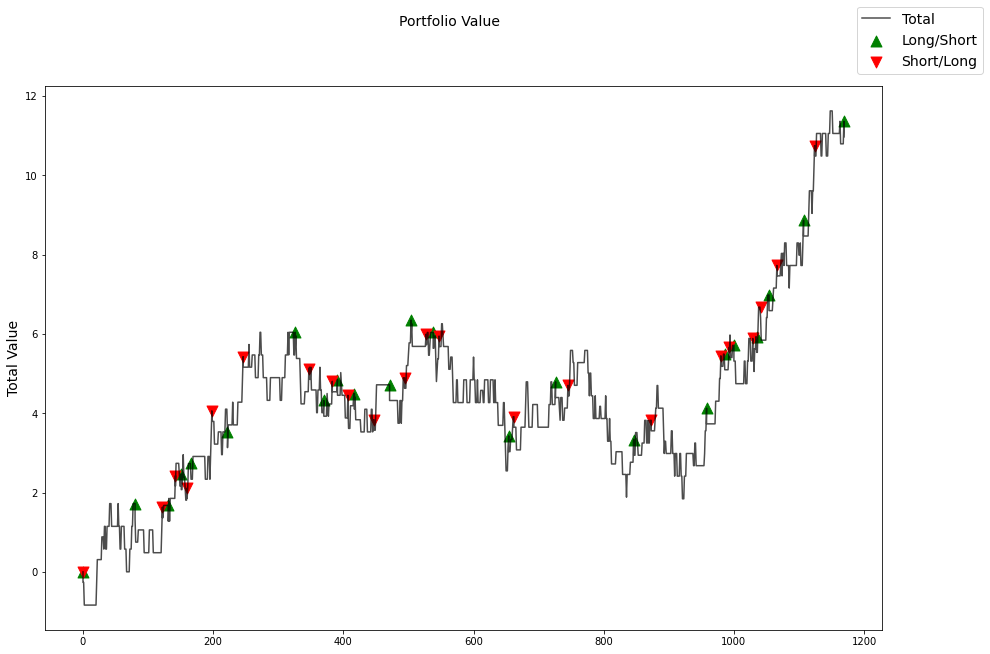

In [6]:
env_test.plot(fig_name='test_env_pnl_medium_cost_dqn_9_242728')

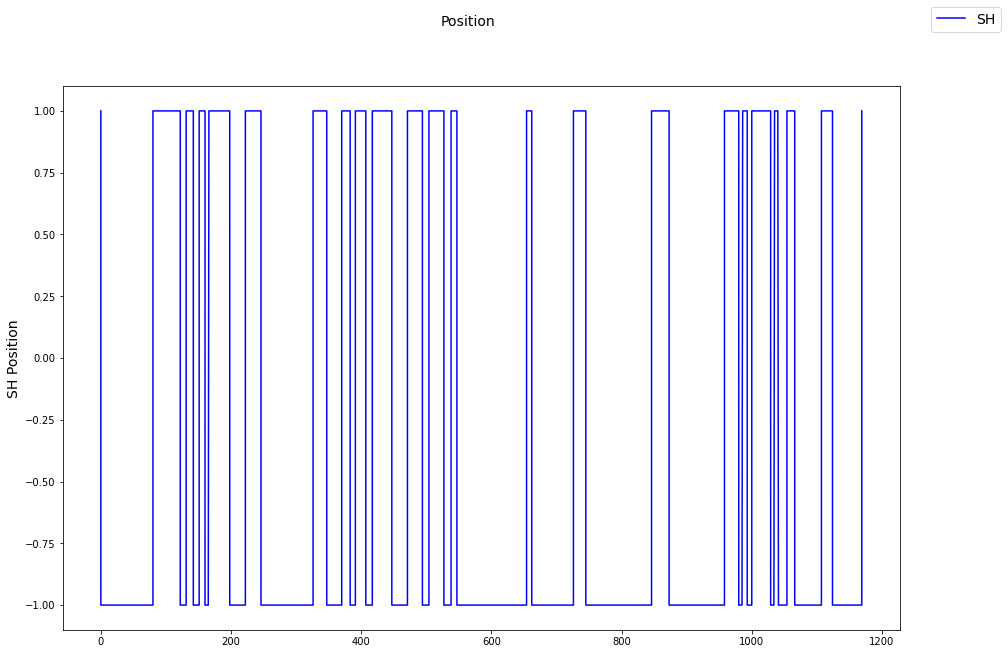

In [7]:
env_test.plot('position_history', fig_name='test_env_positions_medium_cost_dqn_9_242728')

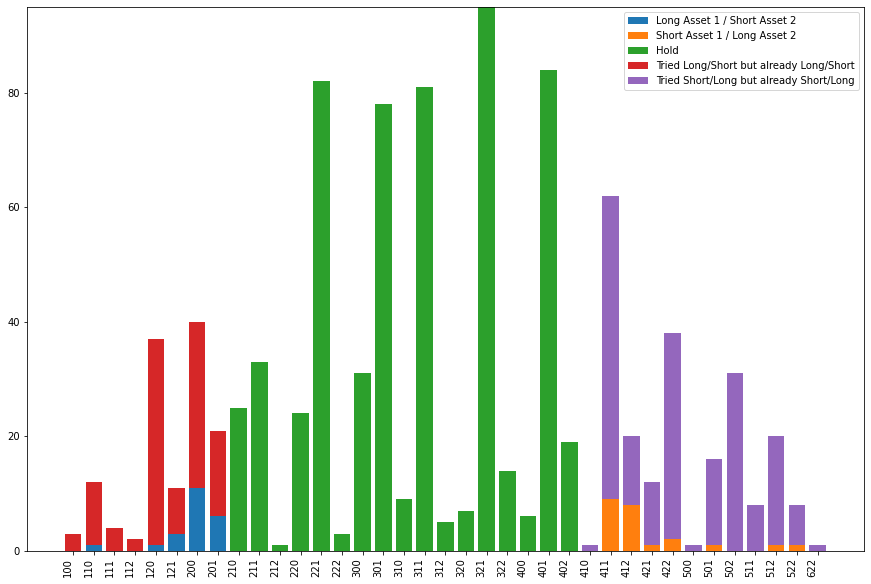

In [8]:
env_test.summarize_decisions(fig_name='test_env_decisions_medium_cost_dqn_9_242728')

In [9]:
import matplotlib.pyplot as plt

In [10]:
q_values = list()
for v in env.mapping.values():
    q_values.append(algo.net.apply(algo.params, np.array([v, 0])))

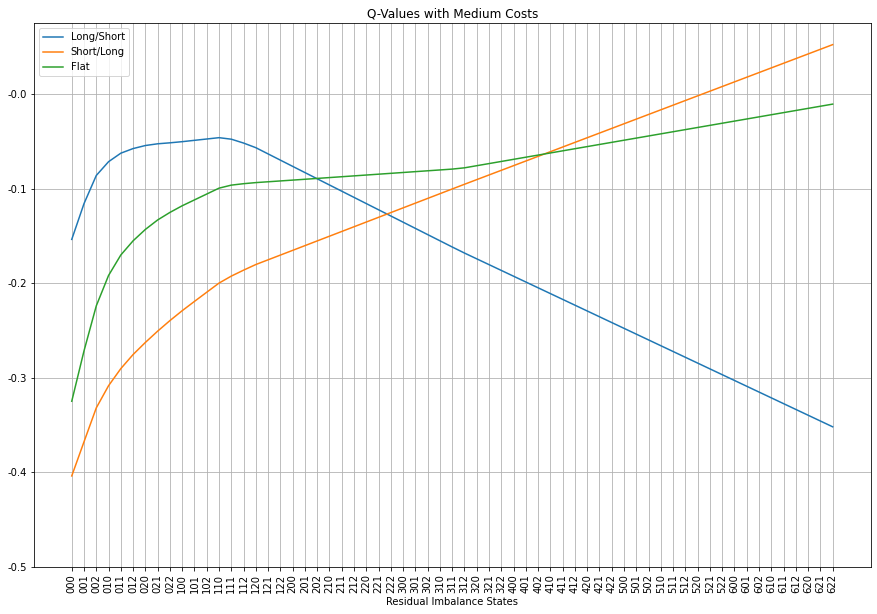

In [30]:
plt.figure(figsize=(15, 10))

labels = {0: 'Long/Short', 1: 'Short/Long', 2: 'Flat'}
states = np.array(list(env.mapping.keys()))

for idx, col in enumerate(np.array(q_values).T):
    sort = np.argsort(-np.array(q_values).T[0])
    plt.plot(states, col, label=labels[idx])
   
plt.title('Q-Values with Medium Costs')
plt.legend()
plt.xticks(rotation=90)
plt.grid()
plt.xlabel('Residual Imbalance States')

mini = -1
maxi = 5.5

plt.yticks(ticks=np.arange(mini, maxi, 0.33)[5:11], labels=np.round(np.arange(-1, 1, 0.1)[5:11], 2))
plt.savefig('figures/q_values_medium_costs_unsorted.png', format='png')
plt.show()